In [46]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe

In [73]:
import split_images
reload(split_images)
from split_images import split_geometry, haversine, calc_segment_count

In [24]:
from analysis_image import AnalysisImage
from keras.preprocessing import image

In [3]:
ee.Authenticate()
ee.Initialize()

In [60]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
FEATURES = ['B2', 'B3', 'B4']

In [234]:
import analysis_image
reload(analysis_image)
from analysis_image import AnalysisImage

In [235]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2023, feature_bands=FEATURES)

In [236]:
img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 600, 600)

In [237]:
folder_path = os.path.join('image_clips', 'tegucigalpa', '2023')
files = tegucigalpa_image.extract_clips_to_folder(folder_path, 'tegucigalpa', x_num_parts, y_num_parts)

  1%|          | 2/391 [00:13<43:28,  6.71s/it]


In [151]:
from tensorflow.keras.applications import EfficientNetB7 as effnet
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_p

In [295]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [296]:
tegu_600_eloisa = Eloisa(name="tegu_600x600_2", db_folder="eloisa_databases", seed=SEED, image_shape=(600, 600, 3))

The database does not yet exist. Creating it.


In [297]:
tegu_600_eloisa.import_images_by_year(folder_path=folder_path, year=2023, bands=[1, 2, 3])

100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


In [298]:
tegu_600_eloisa.extract_features(year=2023, model=effnet, preprocess_input=effnet_p)

1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step


In [293]:
for year in tegu_600_eloisa._data:
    for model_name in tegu_600_eloisa._data[year]:
        if model_name == "image_list":
            continue

        features = tegu_600_eloisa._data[year][model_name]


        for i, row in features.iterrows():

            # Convert features to json
            features_as_json = json.dumps(row.values.flatten().tolist())
            print(len(features[i].values.flatten().tolist()))
            print(features_as_json, year, tegu_600_eloisa.image_names[year][i])

3
[-0.15650415420532227, 0.010746072046458721, 0.011965385638177395, -0.05238432437181473, -0.2028200328350067, 0.17131589353084564, 0.05535317584872246, 0.049675412476062775, 0.43770354986190796, -0.1395472288131714, 0.20086950063705444, 0.11603625863790512, -0.1526675969362259, 0.0696362629532814, 0.04157637432217598, -0.06102224811911583, -0.15425825119018555, 0.04313004016876221, -0.09308585524559021, -0.16657574474811554, -0.1373203843832016, -0.014939443208277225, 0.024926910176873207, -0.018172305077314377, -0.02920444868505001, -0.04853620380163193, 0.3354111611843109, 0.33771800994873047, -0.17277944087982178, -0.023006657138466835, -0.04368162155151367, -0.08570060133934021, -0.12118623405694962, -0.16455692052841187, -0.02059335447847843, -0.11854054033756256, -0.07975977659225464, -0.09020931273698807, -0.07226664572954178, -0.13330911099910736, 0.04131665825843811, -0.07055714726448059, 0.050124045461416245, -0.03229931741952896, -0.010255853645503521, 0.09608983993530273,

In [299]:
tegu_600_eloisa.update_database()

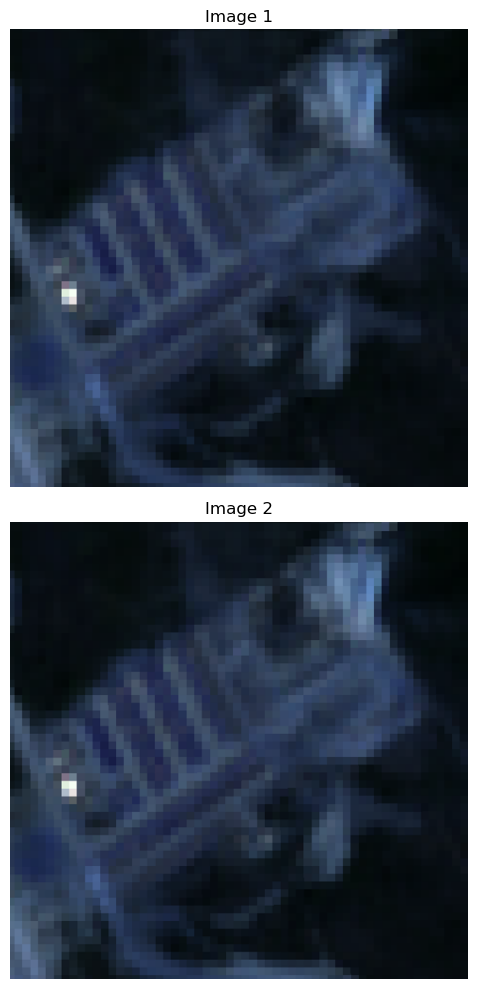

In [209]:
tegu_600_eloisa.show_images_sample(year=2023, rows=2, cols=1)

In [300]:
tegu_600_eloisa.close_db()

# Delete database using os.remove() method
os.remove(tegu_600_eloisa.db_path)